# Яндекс Афиша

# Цель проекта

Помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

# Описание проекта

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.

## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats as st
import numpy as np

In [2]:
visits =  pd.read_csv('/datasets/visits_log.csv') 
orders =  pd.read_csv('/datasets/orders_log.csv')
costs =  pd.read_csv('/datasets/costs.csv')

Визиты:

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Файл visits_log.csv хранит лог сервера с информацией о посещениях сайта. 

Структура visits_log.csv
- Uid — уникальный идентификатор пользователя,
- Device — категория устройства пользователя,
- Start Ts — дата и время начала сессии,
- End Ts — дата и время окончания сессии,
- Source Id — идентификатор источника перехода на сайт.

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
visits.duplicated().sum()  

0

Пропущенных значений и дубликатов нет, данные в End Ts и Start Ts необходимо перевести в формат даты.

Для удобства переименуем колонки:

In [6]:
visits = visits.rename(columns = {'Device' : 'device'
                                  , 'End Ts' : 'end_ts'
                                  , 'Source Id' : 'source_id'
                                  , 'Start Ts' : 'start_ts'
                                  , 'Uid' : 'uid'})

In [7]:
visits['source_id'].unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

Кажется ненмого странным, что нет source_id под номером 8 - выглядит так, будто бы часть данных потерялась. 

In [8]:
visits.groupby('source_id')['uid'].count().sort_values(ascending = False)

source_id
4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: uid, dtype: int64

Самый популярный источник - 4. Меньше всего пользователи перешли на сервис по 6 источнику. 

In [9]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

Пользователи используют два типа девайсов: touch и desktop.

Посмотрим распределение по девайсам: 

In [10]:
visits['device'].describe()

count      359400
unique          2
top       desktop
freq       262567
Name: device, dtype: object

Чаще всего люди пользуются десктопами: 262567 человек зашли на сайт с этого типа устройства. 

Файл orders_log.csv содержит информацию о заказах:

In [11]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Структура orders_log.csv
- Uid — уникальный идентификатор пользователя,
- Buy Ts — дата и время заказа,
- Revenue — сумма заказа.


In [12]:
orders = orders.rename(columns = {'Buy Ts' : 'buy_ts'
                                          , 'Revenue' : 'revenue'
                                          , 'Uid' : 'uid'})

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [14]:
orders.duplicated().sum()  

0

In [15]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

Максимальный заказ - 2633 у.е., минимальный - 0, в среднем - почти 5 у.е.

In [16]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Структура costs.csv
- source_id — идентификатор рекламного источника,
- dt — дата проведения рекламной кампании,
- costs — расходы на эту кампанию.

In [17]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [18]:
orders.duplicated().sum()  

0

Пропущенных значений и дубликатов нет, перевести поле dt в формат даты. 

In [19]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

Максимальный расход на кампанию - 1788 у.е., минимальный - 0.54, в среднем тратится 129 у.е.

Переводим поля с датами в удобный для анализа формат:

In [20]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

### Вывод 

Провели предварительный обзор данных:<br>
 -  Пропущенных значений в файлах нет
 -  Самый популярный источником является №4, наименее популярным - №6
 -  Чаще всего пользователи заходят на сайт с десктопа
 -  Максимальный сумма заказа - 2633 у.е., в среднем пользоваетли тратят почти 5 у.е.
 -  Расходы компании: максимальный расход на кампанию - 1788 у.е., минимальный - 0.54, в среднем тратится 129 у.е.
 
Перевели данные в удобный для анализа формат. <br>
Также среди источниов (source_id) нет номера 8. Думаю, об этом стоит отдельно упомянуть на всякий случай - вдруг часть данных потерялась.

## Анализ данных

### Продуктовые метрики

Рассчитайте DAU, WAU и MAU. Вычислите средние значения этих метрик за весь период. Отобразите изменения метрик во времени на графиках

In [21]:
visits['start_ts_day'] = visits['start_ts'].dt.date
visits['start_ts_week'] = visits['start_ts'].astype('datetime64[W]')
visits['start_ts_month'] = visits['start_ts'].astype('datetime64[M]')
visits['start_ts_year'] = visits['start_ts'].astype('datetime64[Y]')

Посчитаем метрики. Сгруппируем данные по уникальным пользователям и найдём среднее:

In [22]:
dau = visits.groupby(['start_ts_day']).agg({'uid':'nunique'}).mean()
wau = visits.groupby(['start_ts_year', 'start_ts_week']).agg({'uid':'nunique'}).mean()
mau = visits.groupby(['start_ts_year', 'start_ts_month']).agg({'uid':'nunique'}).mean()
print('DAU:', int(dau))
print('WAU:', int(wau))
print('MAU:', int(mau))

DAU: 907
WAU: 5621
MAU: 23228


В день сервисом пользуются примерно 907 человек, в неделю - 5621, а в месяц - 23228.

Построим график изменения DAU:

Text(0, 0.5, 'Кол-во активных пользователей')

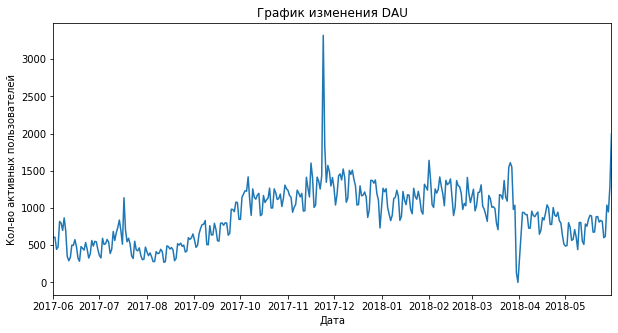

In [23]:
visits.groupby('start_ts_day').agg({'uid':'nunique'}).plot(figsize = (10,5), legend = None)
plt.title('График изменения DAU')
plt.xlabel('Дата')
plt.ylabel('Кол-во активных пользователей')

На графике виден резкое увеличение количества активных пользователей в конце декабря 2017, думаю, это можно объяснить поиском новогодних подарков например. Или выбором мероприятия, на которое можно было бы сходить на каникулах.  <br>
Кроме того интересен и другой скачок - наоборот уменьшение количества пользователей в апреле 2018 года. 


Text(0, 0.5, 'Кол-во активных пользователей')

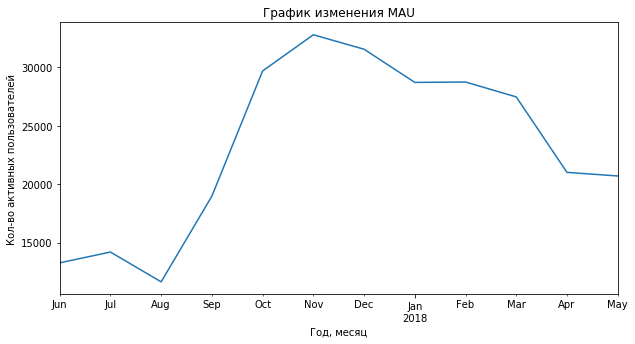

In [24]:
visits.groupby('start_ts_month'
               ).agg({'uid':'nunique'}).plot(figsize = (10,5), legend=None)
               
plt.title('График изменения MAU')
plt.xlabel('Год, месяц')
plt.ylabel('Кол-во активных пользователей')

Интересно выглядит график MAU: с августа 2017 года наблюдается устойчивый рост количества активных пользователей, а после ноября - постепенное снижение. 

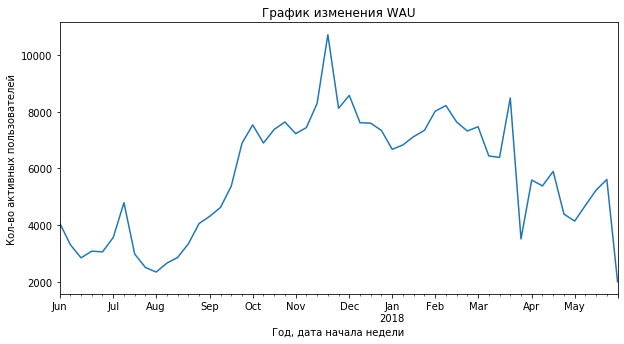

In [25]:
visits.groupby(['start_ts_week']).agg({'uid':'nunique'}).plot(figsize = (10,5), legend=None)
               
plt.title('График изменения WAU')
plt.xlabel('Год, дата начала недели')
plt.ylabel('Кол-во активных пользователей')
plt.show()

Посчитали DAU, WAU, MAU. Построили графики изменения этих показателей. <br>
По графикам видно, что пользовательская активность резко увеличивается в декабре. 

2.1.2. Определите, сколько раз за день пользователи в среднем заходят на сайт. Постройте график, отражающий изменения метрики во времени;

In [26]:
visits_per_day = visits.groupby('start_ts_day').agg({'uid':'count'})
visits_per_day['cnt_unique_users'] = visits.groupby('start_ts_day').agg({'uid':'nunique'})
visits_per_day = visits_per_day.reset_index()

In [27]:
visits_per_day = visits_per_day.rename(columns = {'uid' : 'cnt_sessions'})

Среднее количество сессий в день:

In [28]:
print(round(visits_per_day.mean(), 2)[0])

987.36


In [29]:
visits_per_day['sessions_by_user'] = visits_per_day['cnt_sessions'] / visits_per_day['cnt_unique_users']

In [30]:
visits_per_day['sessions_by_user'].mean()

1.082169644003972

В среднем один пользователь заходит на сайт 1 раз в день. 

Text(0, 0.5, 'Кол-во сессий в день')

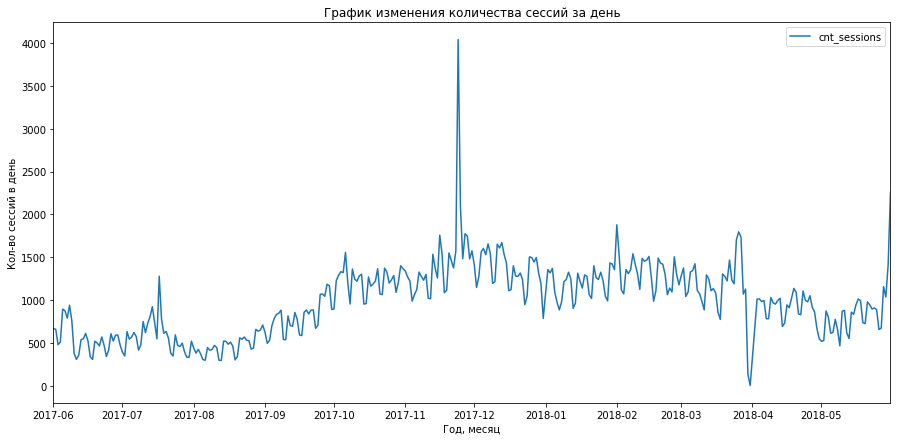

In [31]:
visits_per_day.plot(x = 'start_ts_day', y = 'cnt_sessions', figsize=(15,7))
plt.title('График изменения количества сессий за день')
plt.xlabel('Год, месяц')
plt.ylabel('Кол-во сессий в день')

Text(0, 0.5, 'Кол-во сессий пользователя в день')

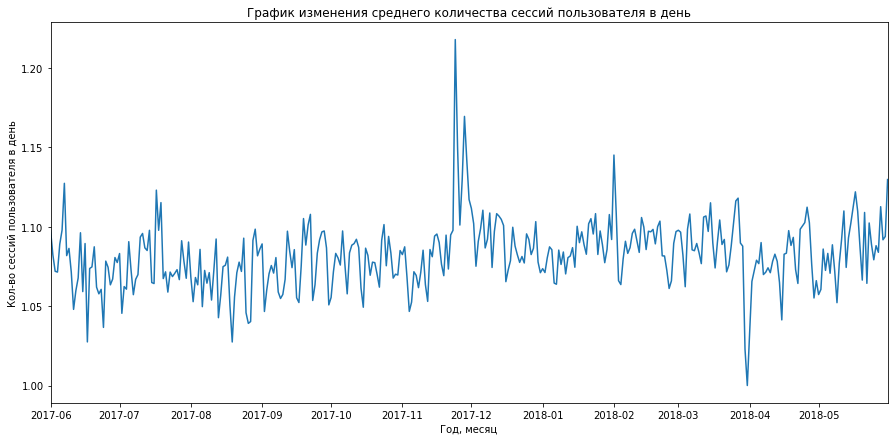

In [32]:
visits_per_day.plot(x = 'start_ts_day', y = 'sessions_by_user', figsize=(15,7), legend = None)
plt.title('График изменения среднего количества сессий пользователя в день')
plt.xlabel('Год, месяц')
plt.ylabel('Кол-во сессий пользователя в день')

Так же как и на предыдущих графиках виден всплеск пользовательской активности в декабре 2017 года. И резкое снижение в апреле 2018.

2.1.3. Исследуйте, сколько времени пользователи проводят на сайте. Узнайте продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, постройте график распределения. Изменение продолжительности сессий во времени изучать необязательно;

In [33]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print(round(visits['duration'].mean(),2))

643.51


В среднем  - 643 секунды.

In [34]:
mean_session = visits[visits['duration'] != '0 seconds']
print(mean_session['duration'].describe())

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: duration, dtype: float64


/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Посмотрим на график распределения:

Text(0, 0.5, 'Частотность')

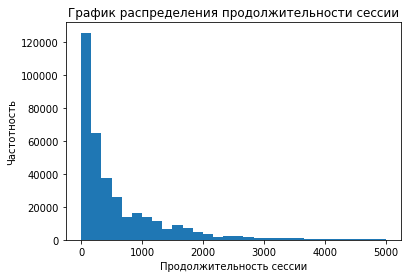

In [35]:
mean_session['duration'].plot(kind = 'hist', bins=30, range = (0, 5000)) 
plt.title('График распределения продолжительности сессии')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Частотность')

Т.к. распределение не является нормальным, то при расчете средней продолжительности сессии mean() использовать нельзя. Посчитаем моду:

In [36]:
mean_session_duration = mean_session['duration'].mode()
print(mean_session_duration)

0    60
dtype: int64


Мода продолжительности одной сессии - 60 секунд.

Выходит, пользователи совсем недолго сидят на сайте - около 1 минуты! Либо сайт настолько удобный, что можно сделать всё, что хотел, за 1 минуту, либо ужасный настолько, что среднестатический пользователь не выдерживает сидеть дольше. Будем надеяться, что первое.<br>
Проверим, как часто пользователи возвращаются на сайт:


2.1.4. Рассчитайте Retention Rate, применяя когортный анализ. Покажите изменения метрики во времени на графике. Найдите средний Retention Rate на второй месяц «жизни» когорт.

Сгруппируем данные по дате начала сессии, для каждого пользователя найдем дату первой сессии:

In [37]:
first_session_date_by_users = visits.groupby(['uid']).agg({'start_ts':'min', 'source_id':'first'})
print(first_session_date_by_users.head()) 

                           start_ts  source_id
uid                                           
11863502262781  2018-03-01 17:27:00          3
49537067089222  2018-02-06 15:55:00          2
297729379853735 2017-06-07 18:47:00          3
313578113262317 2017-09-18 22:49:00          2
325320750514679 2017-09-30 14:29:00          5


Изменяем название столбца:

In [38]:
first_session_date_by_users.columns = ['first_session_date', 'first_source']

Присоединяем полученные данные к имеющейся таблице:

In [39]:
visits = visits.join(first_session_date_by_users, on='uid')
visits

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month,start_ts_year,duration,first_session_date,first_source
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,1080,2017-12-20 17:20:00,4
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01,1680,2018-02-19 16:53:00,2
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,0,2017-07-01 01:54:00,5
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01,1440,2018-03-09 20:05:00,9
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01,0,2017-12-27 14:06:00,3
...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-07-27,2017-07-01,2017-01-01,19,2017-07-29 19:07:00,2
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2018-01-25,2018-01-01,2018-01-01,19,2018-01-25 17:38:00,1
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2018-03-01,2018-03-01,2018-01-01,19,2018-03-03 10:12:00,4
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-11-02,2017-11-01,2017-01-01,19,2017-11-02 10:12:00,5


In [40]:
visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')
visits

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month,start_ts_year,duration,first_session_date,first_source,first_session_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,1080,2017-12-20 17:20:00,4,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01,1680,2018-02-19 16:53:00,2,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,0,2017-07-01 01:54:00,5,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01,1440,2018-03-09 20:05:00,9,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01,0,2017-12-27 14:06:00,3,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-07-27,2017-07-01,2017-01-01,19,2017-07-29 19:07:00,2,2017-07-01
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2018-01-25,2018-01-01,2018-01-01,19,2018-01-25 17:38:00,1,2018-01-01
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2018-03-01,2018-03-01,2018-01-01,19,2018-03-03 10:12:00,4,2018-03-01
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-11-02,2017-11-01,2017-01-01,19,2017-11-02 10:12:00,5,2017-11-01


Посчитаем lifetime:

In [41]:
visits['lifetime'] = ((visits['start_ts_month'] - visits['first_session_month']) / np.timedelta64(1, 'M')).round().astype('int')

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённую «неделю жизни»:

In [42]:
cohorts = visits.groupby(['first_session_month','lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_session_month,lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю:

In [43]:
initial_users_count = cohorts[cohorts['lifetime'] == 0][['first_session_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [44]:
cohorts = cohorts.merge(initial_users_count, on='first_session_month') 

Наконец, рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте:

In [45]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

Построим сводную таблицу и создадим тепловую карту:

In [46]:
retention_pivot = cohorts.pivot_table(
    index = 'first_session_month',
    columns = 'lifetime',
    values = 'retention',
    aggfunc = 'sum'
)

Для наглядности, удалим данные за нулевой месяц когорты:

In [47]:
retention_pivot = retention_pivot.drop([0], axis=1)

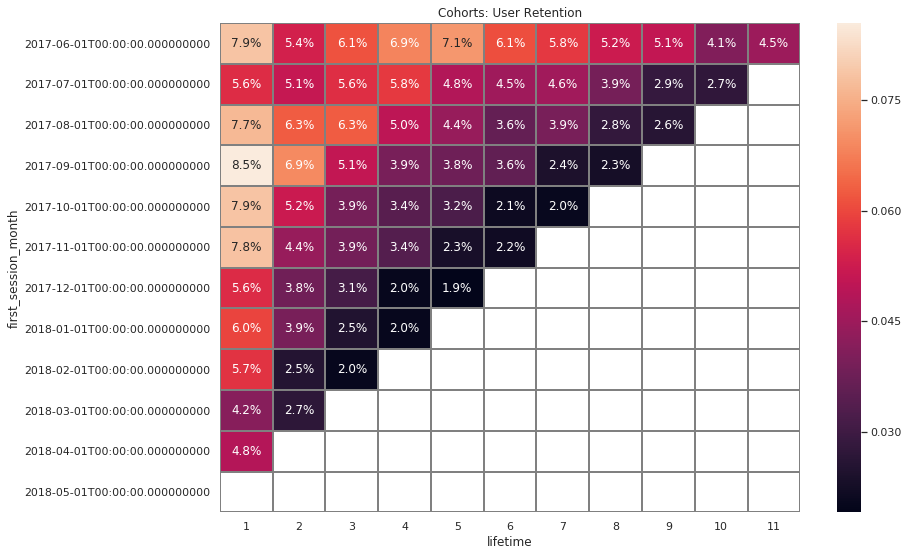

In [48]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

Retention Rate значительно снижается уже с первого месяца: не больше 10%. Такое повторяется во всех когортах. 


In [49]:
rr_mean_second_month = cohorts[cohorts['lifetime'] == 1]['retention'].mean()
print('Средний Retention Rate на второй месяц жизни когорты составляет {:.1%}'.format(rr_mean_second_month))

Средний Retention Rate на второй месяц жизни когорты составляет 6.5%


#### Вывод

Построили графики изменения DAU, WAU и MAU по времени. Наблюдается резкое увеличение активности в ноябре-декабре 2017 года. <br>
- Продолжительность сессии составляет примерно 1 минуту. 
Провели когортный анализ.<br> 
Посчитали Retention Rate: этот показатель значительно снижается уже на второй месяц и в целом не повышается выше 10%. 
    Средний RR на второй месяц жизни когорты составляет 6.5%, что говорит о том, что люди редко возвращаются на сайт: скорее всего, это может быть связано с тем, что в целом нет необходимости ежедневно сидеть/возвращаться на сайт, продающий билеты. <br>
    Динамика от когорты к когорте также оставляет желать лучшего: с каждой когортой уменьшается RR: Например, Когорта апреля 2018 показывается RR = 2,7% уже на второй месяц жизни, в то время как когорта июля 2017 года приблизилась к такой цифре только на десятый месяц.  <br>
Такое изменение RR по когортам может свидетельствовать, например, о переменах в работе сайта, которые не понравились пользователям. 


### Метрики электронной коммерции

#### Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Изучать изменение этой метрики во времени необязательно;

Выделим первые сессии:

In [50]:
first_sessions = visits.groupby('uid')['first_session_date'].min()

Определим дату первого заказа: 

In [51]:
first_order_date = orders.groupby('uid')[
    'buy_ts'
].min(
).to_frame('first_order_ts')
first_order_date.head()

,first_order_ts
uid,
313578113262317,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00
2464366381792757,2018-01-28 15:54:00
2551852515556206,2017-11-24 10:14:00


Объединим полученные данные:

In [52]:
first_orders = first_order_date.join(first_sessions, on = 'uid')    
first_orders

,first_order_ts,first_session_date
uid,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...
18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00
18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00
18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00


Посчитаем время от первой сессии до первой покупки:

In [53]:
first_orders['time_to_first_purchase'] = (first_orders['first_order_ts'] - first_orders['first_session_date']) / np.timedelta64(1, 'm')
first_orders['time_to_first_purchase'].mean()
print('Мода времени с момента первого посещения сайта до совершения покупки: {} минут(а)'.format(int(
                        first_orders['time_to_first_purchase'].mode()))
     )
print('Среднее количество минут с момента первого посещения сайта до совершения покупки: {}'.format(int(
                        first_orders['time_to_first_purchase'].mean()))
     )
print('Что в днях составляет: {} дней'.format(int(first_orders['time_to_first_purchase'].mean()/60/24)))
print('Медиана количества минут с момента первого посещения сайта до совершения покупки: {}'.format(int(
                        first_orders['time_to_first_purchase'].median()))
     )

Мода времени с момента первого посещения сайта до совершения покупки: 1 минут(а)
Среднее количество минут с момента первого посещения сайта до совершения покупки: 24340
Что в днях составляет: 16 дней
Медиана количества минут с момента первого посещения сайта до совершения покупки: 16


Чаще всего пользователи делают покупку в течение 1 минуты! Это очень быстро! 

#### Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. Изучать изменение этой метрики во времени необязательно;

Добавим к заказам данные о первой дате покупки:

In [54]:
orders = orders.join(first_orders, on = 'uid')
orders.head()

,buy_ts,revenue,uid,first_order_ts,first_session_date,time_to_first_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,1.0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,11.0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,2.0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,15.0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,27.0


In [55]:
orders['first_order_month'] = orders['first_order_ts'].astype(
    'datetime64[M]'
)
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')


In [56]:
orders['cohort_lifetime'] = ((orders['order_month'] - orders['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')

In [57]:
initial_users = orders[orders['cohort_lifetime'] == 0][
    ['first_order_month', 'uid']
]
 
initial_users = initial_users.rename(columns={'uid':'cohort_users'})
 
initial_users = initial_users.groupby('first_order_month').agg({'cohort_users':'nunique'}).reset_index()
initial_users

,first_order_month,cohort_users
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [58]:
orders_grouped_by_cohorts = orders.groupby(
    ['first_order_month', 'cohort_lifetime']
).agg({'buy_ts': 'count'}).reset_index() 
orders_grouped_by_cohorts = orders_grouped_by_cohorts.merge(initial_users,
                                      on = 'first_order_month'
                                                           )
orders_grouped_by_cohorts

,first_order_month,cohort_lifetime,buy_ts,cohort_users
0,2017-06-01,0,2354,2023
1,2017-06-01,1,177,2023
2,2017-06-01,2,174,2023
3,2017-06-01,3,226,2023
4,2017-06-01,4,292,2023
...,...,...,...,...
74,2018-03-01,2,176,3533
75,2018-04-01,0,2495,2276
76,2018-04-01,1,195,2276
77,2018-05-01,0,3249,2988


In [59]:
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')
orders_grouped_by_cohorts['avg_orders'] = (orders_grouped_by_cohorts['buy_ts']
                                /orders_grouped_by_cohorts['cohort_users'])

orders_grouped_by_cohorts

,first_order_month,cohort_lifetime,buy_ts,cohort_users,avg_orders
0,2017-06,0,2354,2023,1.163618
1,2017-06,1,177,2023,0.087494
2,2017-06,2,174,2023,0.086011
3,2017-06,3,226,2023,0.111715
4,2017-06,4,292,2023,0.144340
...,...,...,...,...,...
74,2018-03,2,176,3533,0.049816
75,2018-04,0,2495,2276,1.096221
76,2018-04,1,195,2276,0.085677
77,2018-05,0,3249,2988,1.087349


In [60]:
purchases = orders_grouped_by_cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='avg_orders',
    aggfunc='mean').cumsum(axis=1).round(2)

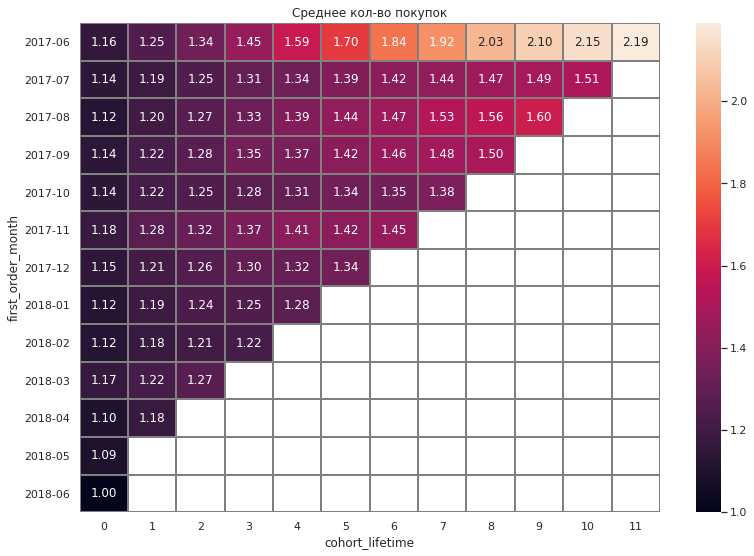

In [61]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Среднее кол-во покупок')
sns.heatmap(purchases, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

В целом, идет небольшое увеличение среднего количества покупок. 

#### Рассчитайте средний чек, применяя группировку по времени совершения покупки. Когортный анализ не подходит — он может исказить расчёты. Постройте график, отражающий изменения метрики во времени

In [62]:
orders

,buy_ts,revenue,uid,first_order_ts,first_session_date,time_to_first_purchase,first_order_month,order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,1.0,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,11.0,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,2.0,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,15.0,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,27.0,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-31 09:11:00,879.0,2018-05-01,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-31 23:05:00,45.0,2018-05-01,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-31 23:52:00,2.0,2018-05-01,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2017-10-23 12:32:00,317484.0,2018-05-01,2018-05-01,0


In [63]:
orders['buy_ts_day'] = orders['buy_ts'].dt.date

In [64]:
avg_revenue = orders.groupby('buy_ts_day')['revenue'].mean().reset_index()
avg_revenue

,buy_ts_day,revenue
0,2017-06-01,4.056875
1,2017-06-02,2.919910
2,2017-06-03,2.484776
3,2017-06-04,2.957727
4,2017-06-05,2.742174
...,...,...
359,2018-05-28,3.936170
360,2018-05-29,2.598201
361,2018-05-30,4.911971
362,2018-05-31,7.563803


In [65]:
avg_revenue['revenue'].describe()

count    364.000000
mean       4.936188
std        2.021881
min        1.948000
25%        3.960635
50%        4.561548
75%        5.411037
max       29.133313
Name: revenue, dtype: float64

Средний чек - 4,93. Минимальный - 1, 9, а вот максимальный - 29 у.е. <br>
Посмотрим график изменения этой метрики:

Text(0, 0.5, 'Средний чек')

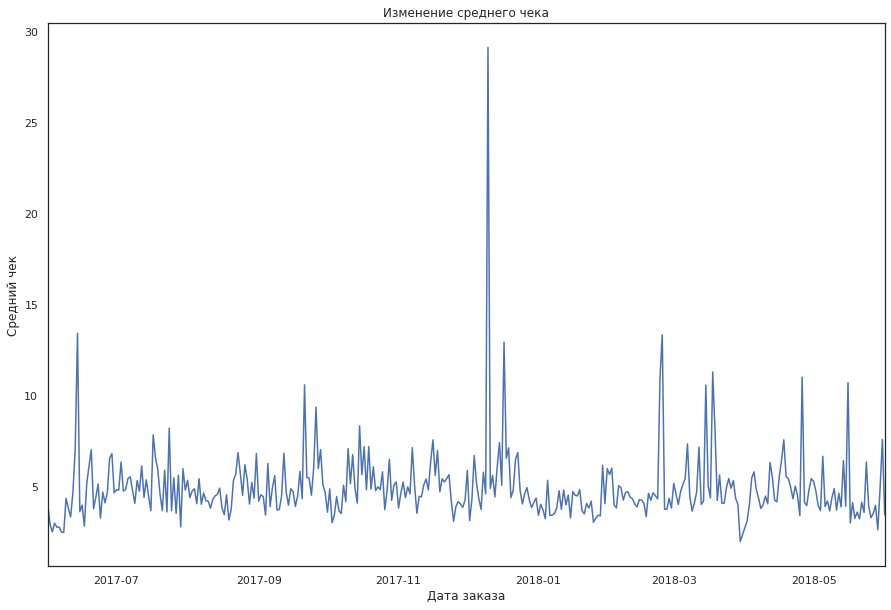

In [66]:
avg_revenue.plot(x = 'buy_ts_day', y = 'revenue', figsize = (15,10) , legend = False)
plt.title('Изменение среднего чека')
plt.xlabel('Дата заказа')
plt.ylabel('Средний чек')

Максимальный пик - в конце 2017 года.

#### Выясните, как меняется LTV на покупателя по когортам. Помните, что LTV — накопительная метрика. Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%. Отразите изменения метрики во времени на графике;

In [67]:
orders

,buy_ts,revenue,uid,first_order_ts,first_session_date,time_to_first_purchase,first_order_month,order_month,cohort_lifetime,buy_ts_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,1.0,2017-06-01,2017-06-01,0,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,11.0,2017-06-01,2017-06-01,0,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,2.0,2017-06-01,2017-06-01,0,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,15.0,2017-06-01,2017-06-01,0,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,27.0,2017-06-01,2017-06-01,0,2017-06-01
...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-31 09:11:00,879.0,2018-05-01,2018-05-01,0,2018-05-31
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-31 23:05:00,45.0,2018-05-01,2018-05-01,0,2018-05-31
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-31 23:52:00,2.0,2018-05-01,2018-05-01,0,2018-05-31
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2017-10-23 12:32:00,317484.0,2018-05-01,2018-05-01,0,2018-05-31


In [68]:
costs['month'] = costs['dt'].astype('datetime64[M]') 

Посчитаем количество новых покупателей (n_buyers) за каждый месяц:

In [69]:
cohort_sizes = (
    orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
print(cohort_sizes.head()) 

  first_order_month  n_buyers
0        2017-06-01      2023
1        2017-07-01      1923
2        2017-08-01      1370
3        2017-09-01      2581
4        2017-10-01      4340


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. Сбросим индекс методом reset_index():

In [70]:
cohorts = (
    orders.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
print(cohorts.head()) 

  first_order_month order_month  revenue
0        2017-06-01  2017-06-01  9557.49
1        2017-06-01  2017-07-01   981.82
2        2017-06-01  2017-08-01   885.34
3        2017-06-01  2017-09-01  1931.30
4        2017-06-01  2017-10-01  2068.58


Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [71]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
print(report.head()) 

  first_order_month  n_buyers order_month  revenue
0        2017-06-01      2023  2017-06-01  9557.49
1        2017-06-01      2023  2017-07-01   981.82
2        2017-06-01      2023  2017-08-01   885.34
3        2017-06-01      2023  2017-09-01  1931.30
4        2017-06-01      2023  2017-10-01  2068.58


In [72]:
margin_rate = 1


report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
print(report) 

   first_order_month  n_buyers order_month   revenue        gp  age
0         2017-06-01      2023  2017-06-01   9557.49   9557.49    0
1         2017-06-01      2023  2017-07-01    981.82    981.82    1
2         2017-06-01      2023  2017-08-01    885.34    885.34    2
3         2017-06-01      2023  2017-09-01   1931.30   1931.30    3
4         2017-06-01      2023  2017-10-01   2068.58   2068.58    4
..               ...       ...         ...       ...       ...  ...
74        2018-03-01      3533  2018-05-01   1114.87   1114.87    2
75        2018-04-01      2276  2018-04-01  10600.69  10600.69    0
76        2018-04-01      2276  2018-05-01   1209.92   1209.92    1
77        2018-05-01      2988  2018-05-01  13925.76  13925.76    0
78        2018-06-01         1  2018-06-01      3.42      3.42    0

[79 rows x 6 columns]


In [73]:
report['ltv'] = report['gp'] / report['n_buyers']

#средний LTV
output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
)

output.fillna('') 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.02253,0.735502,0.95044,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.14182,0.161232,0.147145,0.155673,
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.28354,0.210664,0.405007,0.292212,0.187978,,
2017-09-01,5.644529,1.11759,0.52093,3.97579,0.400558,0.647067,0.701608,0.24315,0.184006,,,
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.15156,0.120362,0.0848157,0.11547,,,,
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,,,,,
2017-12-01,4.738191,0.260374,0.925097,1.06527,0.31293,0.338047,,,,,,
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.0626979,,,,,,,
2018-02-01,4.156987,0.278274,0.0785155,0.0741441,,,,,,,,


И накопительный LTV:

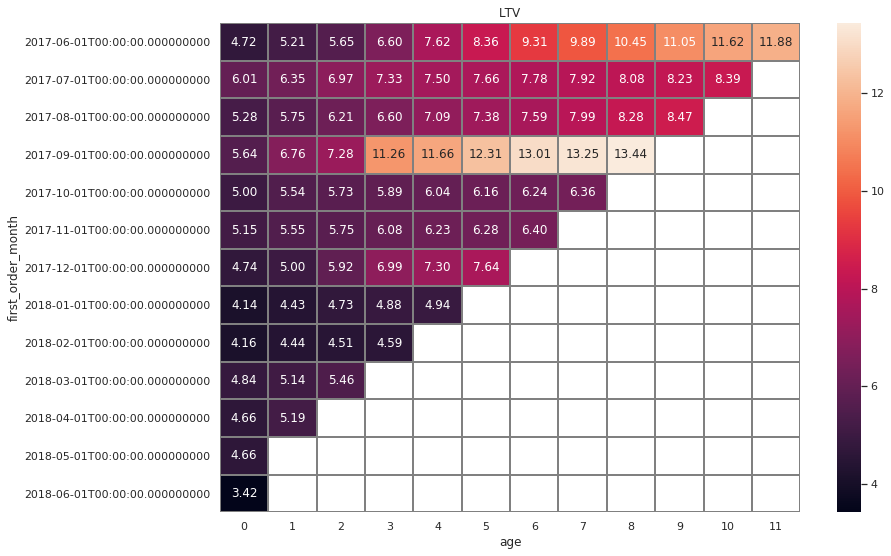

In [74]:
output_cumsum = output.cumsum(axis = 1)
output_cumsum
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(output_cumsum, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

Особенно здесь выделяется когорта 2017-09-01. LTV там выше всех остальных. <br>
А вот когорты 2018 года наоборот показывают самые низкие показатели. 

средний LTV  на 6 месяц когорты:

In [75]:
output_cumsum[6].mean()

8.387686429758398

Посчитали LTV: В среднем на 6 месяц когорты пользователь приносит около 8 у.е. Хороший это показатель для бизнеса или нет, можно выяснить, только посчитав, во сколько компании обходится привлечение одного клиента.

### Маркетинговые метрики

#### Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируйте изменения метрик во времени;

In [76]:
print('Всего потрачено на маркетинг {} '.format(costs['costs'].sum()))

Всего потрачено на маркетинг 329131.62 


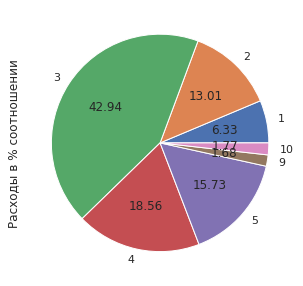

               costs
source_id           
3          141321.63
4           61073.60
5           51757.10
2           42806.04
1           20833.27
10           5822.49
9            5517.49


In [77]:
costs.groupby('source_id').sum().plot(y = 'costs', autopct='%.2f', kind = 'pie', figsize = (5, 5), legend = False)
plt.ylabel('Расходы в % соотношении')
plt.show()
print(costs.groupby('source_id').sum().sort_values(by = 'costs', ascending = False))

Больше всего было потрачено на 3 source_id: 141321.63. Меньше всего - на 9:  5517.49.

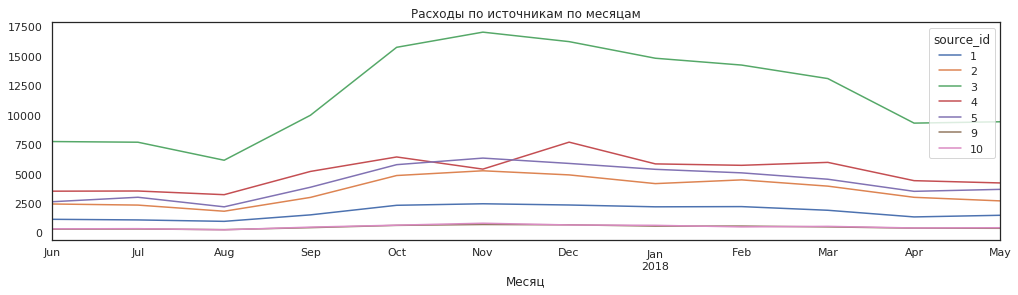

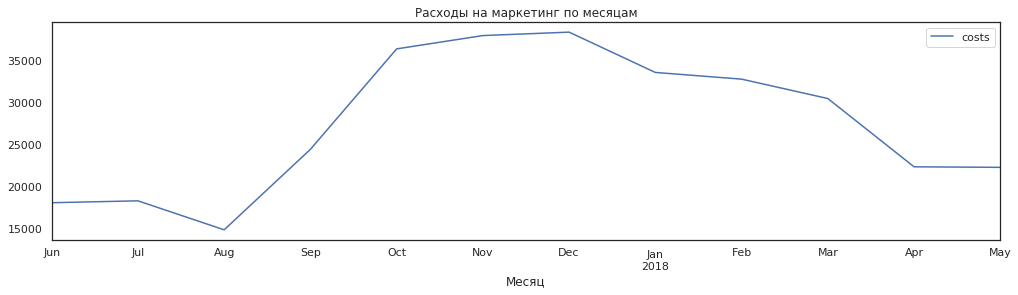

In [78]:
costs_pivot = costs.pivot_table(index = 'month', columns = 'source_id', values = 'costs', aggfunc = 'sum')
costs_pivot.plot(figsize = (17,4), title = 'Расходы по источникам по месяцам')
plt.xlabel('Месяц')
plt.show()

costs.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum').plot(title = 'Расходы на маркетинг по месяцам', figsize = (17,4))
plt.xlabel('Месяц')
plt.show()

Посмотрим распределение количества пользователей по источникам:

In [79]:
print(visits.groupby('source_id').agg({'uid':'nunique'}).sort_values(by = 'uid', ascending = False))

             uid
source_id       
4          83525
3          74756
5          56974
2          26245
1          18999
9           9264
10          8067
7             34
6              6


Расходы на маркетинг в августе 2017 года были самыми низкими - что, видимо, сказалось и на пользовательской активности. Как мы видели выше, в августе были самые низкие показатели.  <br>
Больше всего было потрачено на 3 source_id, при этом по количеству привлеченных клиентов он на втором месте.

#### Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразите изменения метрик на графиках

In [80]:
monthly_costs = costs.groupby('month')['costs'].sum()
monthly_costs

month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

In [81]:
report_new = pd.merge(
    report, monthly_costs, left_on='first_order_month', right_on='month'
)
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new 

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,18015.00,8.905091
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,18015.00,8.905091
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637,18015.00,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671,18015.00,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531,18015.00,8.905091
...,...,...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,1063.05,1,0.300892,30415.27,8.608907
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559,30415.27,8.608907
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0,4.657597,22289.38,9.793225
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1,0.531599,22289.38,9.793225


In [82]:
report_new['cac'].mean()

9.319905176921116

В среднем привлечение одного пользователя обходится компании в 9 у.е.! Что выше, чем прибыль, которую в среднем приносит пользователь. 

Посчитаем траты бизнеса на источники трафика в месяц:

In [83]:
monthly_costs_by_source = costs.groupby(['month', 'source_id'])['costs'].sum().reset_index()
monthly_costs_by_source


,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


In [84]:
first_orders = pd.merge(
    first_orders
    , orders[['uid', 'first_order_ts', 'first_order_month', 'order_month', 'revenue']]
    , left_on = ['uid'
                 , 'first_order_ts']
    , right_on = ['uid'
                  , 'first_order_ts'])
first_orders

,uid,first_order_ts,first_session_date,time_to_first_purchase,first_order_month,order_month,revenue
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022.0,2018-01-01,2018-01-01,0.55
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0,2017-06-01,2017-06-01,1.22
2,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0,2017-06-01,2017-06-01,1.83
3,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79.0,2017-10-01,2017-10-01,73.33
4,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184.0,2018-01-01,2018-01-01,2.44
...,...,...,...,...,...,...,...
50410,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,7.0,2017-09-01,2017-09-01,0.24
50411,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,7.0,2017-09-01,2017-09-01,0.12
50412,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,333303.0,2018-03-01,2018-03-01,4.22
50413,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00,148893.0,2018-02-01,2018-02-01,9.78


In [85]:
first_orders_by_source = pd.merge(
    first_orders
    , first_session_date_by_users
    , right_on = ['uid'
                  , 'first_session_date']
    , left_on = ['uid'
                 , 'first_session_date']
)

first_orders_by_source

,uid,first_order_ts,first_session_date,time_to_first_purchase,first_order_month,order_month,revenue,first_source
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022.0,2018-01-01,2018-01-01,0.55,2
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0,2017-06-01,2017-06-01,1.22,10
2,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0,2017-06-01,2017-06-01,1.83,10
3,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79.0,2017-10-01,2017-10-01,73.33,3
4,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184.0,2018-01-01,2018-01-01,2.44,5
...,...,...,...,...,...,...,...,...
50410,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,7.0,2017-09-01,2017-09-01,0.24,3
50411,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,7.0,2017-09-01,2017-09-01,0.12,3
50412,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,333303.0,2018-03-01,2018-03-01,4.22,2
50413,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00,148893.0,2018-02-01,2018-02-01,9.78,3


In [86]:
orders_revenue_by_source = first_orders_by_source.groupby(
    ['first_order_month'
     , 'first_source'
     , 'order_month']
    ).agg(
    {'uid' : 'nunique'
    , 'revenue' : 'sum'}
).reset_index()
orders_revenue_by_source

,first_order_month,first_source,order_month,uid,revenue
0,2017-06-01,1,2017-06-01,203,1168.45
1,2017-06-01,1,2017-07-01,11,362.94
2,2017-06-01,1,2017-08-01,10,153.72
3,2017-06-01,1,2017-09-01,13,695.88
4,2017-06-01,1,2017-10-01,14,760.74
...,...,...,...,...,...
510,2018-05-01,4,2018-05-01,767,3616.23
511,2018-05-01,5,2018-05-01,510,2103.24
512,2018-05-01,9,2018-05-01,53,200.38
513,2018-05-01,10,2018-05-01,117,478.93


In [87]:
orders_revenue_by_source = orders_revenue_by_source.rename(columns= 
                                                           {'uid' : 'n_buyers'})

In [88]:
report_by_source = pd.merge(
    orders_revenue_by_source
    , monthly_costs_by_source
    , left_on = ['order_month', 'first_source']
                                , right_on = ['month', 'source_id'])

report_by_source

,first_order_month,first_source,order_month,n_buyers,revenue,month,source_id,costs
0,2017-06-01,1,2017-06-01,203,1168.45,2017-06-01,1,1125.61
1,2017-06-01,1,2017-07-01,11,362.94,2017-07-01,1,1072.88
2,2017-07-01,1,2017-07-01,211,1622.07,2017-07-01,1,1072.88
3,2017-06-01,1,2017-08-01,10,153.72,2017-08-01,1,951.81
4,2017-07-01,1,2017-08-01,8,210.14,2017-08-01,1,951.81
...,...,...,...,...,...,...,...,...
508,2017-10-01,10,2018-04-01,1,3.67,2018-04-01,10,388.25
509,2017-11-01,10,2018-04-01,1,1.47,2018-04-01,10,388.25
510,2018-02-01,10,2018-04-01,3,15.89,2018-04-01,10,388.25
511,2018-03-01,10,2018-04-01,4,11.79,2018-04-01,10,388.25


In [89]:
report_by_source['cac'] = report_by_source.query('first_order_month == order_month')['costs'] / report_by_source.query('first_order_month == order_month')['n_buyers']
report_by_source

,first_order_month,first_source,order_month,n_buyers,revenue,month,source_id,costs,cac
0,2017-06-01,1,2017-06-01,203,1168.45,2017-06-01,1,1125.61,5.544877
1,2017-06-01,1,2017-07-01,11,362.94,2017-07-01,1,1072.88,NaN
2,2017-07-01,1,2017-07-01,211,1622.07,2017-07-01,1,1072.88,5.084739
3,2017-06-01,1,2017-08-01,10,153.72,2017-08-01,1,951.81,NaN
4,2017-07-01,1,2017-08-01,8,210.14,2017-08-01,1,951.81,NaN
...,...,...,...,...,...,...,...,...,...
508,2017-10-01,10,2018-04-01,1,3.67,2018-04-01,10,388.25,NaN
509,2017-11-01,10,2018-04-01,1,1.47,2018-04-01,10,388.25,NaN
510,2018-02-01,10,2018-04-01,3,15.89,2018-04-01,10,388.25,NaN
511,2018-03-01,10,2018-04-01,4,11.79,2018-04-01,10,388.25,NaN


<a class="anchor" id="21-bullet">

In [90]:
report_by_source.groupby('source_id')['cac'].mean().sort_values(ascending = False)

source_id
3     15.884857
2     10.087368
5      7.553257
4      6.687370
1      5.600034
10     5.259864
9      4.301936
Name: cac, dtype: float64

source_id 3, на который потратили больше всего денег, оказался и самым дорогим источником привлечения пользователей: САС равен 15,8. 
Дешевле всего обходится привлечение клиента по источникам № 1, 9, 10.

Посмотрим, как распределилась выручка по источникам:

In [91]:
report_by_source.groupby('source_id')['revenue'].mean().sort_values(ascending = False)

source_id
2     835.285385
4     672.773462
3     568.175385
5     517.409103
1     494.359744
9      95.634865
10     83.904898
Name: revenue, dtype: float64

In [92]:
report_by_source['gp'] = report_by_source['revenue'] * margin_rate
report_by_source['ltv'] = report_by_source['gp'] / report_by_source['n_buyers']

report_by_source['age'] = (
    report_by_source['order_month'] - report_by_source['first_order_month']
) / np.timedelta64(1, 'M')
report_by_source['age'] = report_by_source['age'].round().astype('int')

report_by_source

,first_order_month,first_source,order_month,n_buyers,revenue,month,source_id,costs,cac,gp,ltv,age
0,2017-06-01,1,2017-06-01,203,1168.45,2017-06-01,1,1125.61,5.544877,1168.45,5.755911,0
1,2017-06-01,1,2017-07-01,11,362.94,2017-07-01,1,1072.88,NaN,362.94,32.994545,1
2,2017-07-01,1,2017-07-01,211,1622.07,2017-07-01,1,1072.88,5.084739,1622.07,7.687536,0
3,2017-06-01,1,2017-08-01,10,153.72,2017-08-01,1,951.81,NaN,153.72,15.372000,2
4,2017-07-01,1,2017-08-01,8,210.14,2017-08-01,1,951.81,NaN,210.14,26.267500,1
...,...,...,...,...,...,...,...,...,...,...,...,...
508,2017-10-01,10,2018-04-01,1,3.67,2018-04-01,10,388.25,NaN,3.67,3.670000,6
509,2017-11-01,10,2018-04-01,1,1.47,2018-04-01,10,388.25,NaN,1.47,1.470000,5
510,2018-02-01,10,2018-04-01,3,15.89,2018-04-01,10,388.25,NaN,15.89,5.296667,2
511,2018-03-01,10,2018-04-01,4,11.79,2018-04-01,10,388.25,NaN,11.79,2.947500,1


In [93]:
report_by_source.groupby('source_id')['cac'].mean().sort_values(ascending = False)

source_id
3     15.884857
2     10.087368
5      7.553257
4      6.687370
1      5.600034
10     5.259864
9      4.301936
Name: cac, dtype: float64

Дороже всего компании обходится привлечение клиентов через 3 источник. Дешевле всего - 9.

In [94]:
report_by_source.groupby('source_id')['revenue'].mean().sort_values(ascending = False)

source_id
2     835.285385
4     672.773462
3     568.175385
5     517.409103
1     494.359744
9      95.634865
10     83.904898
Name: revenue, dtype: float64

Больше всего прибыли принес источник 2. Меньше всего - 10. 

#### Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Постройте графики, отражающие изменения метрик во времени.

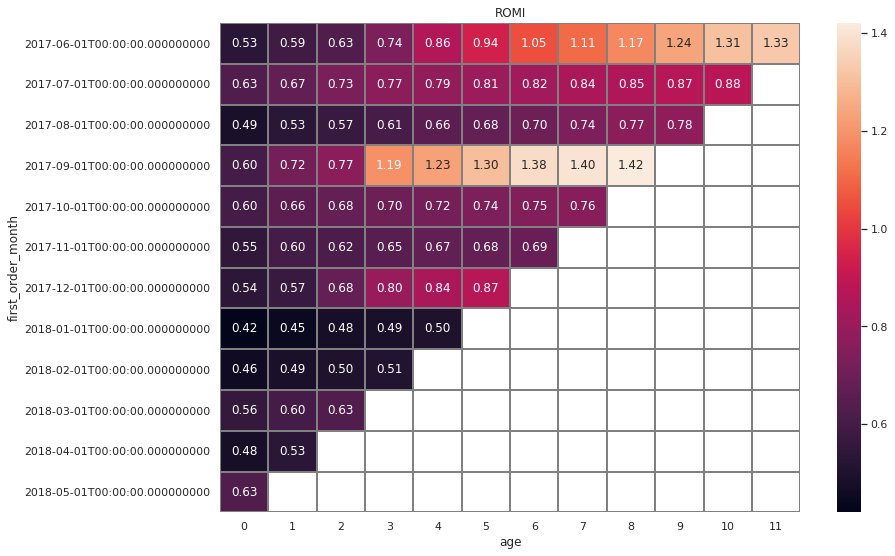

In [95]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean'
)

output.cumsum(axis=1).round(2) 

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI')
sns.heatmap(output.cumsum(axis=1).round(2) , annot=True, fmt='.2f', linewidths=1, linecolor='gray')

Лучше всех здесь выглядит сентябрьская когорта: она окупилась уже на 4 месяц (ROMI = 1.19). Июньская когорта окупилась на 7 месяц (ROMI = 1.05). А вот с июльской и августовской когортой всё так радужно: ROMI только-только приближается к единице. 

In [96]:
output.cumsum(axis=1).mean() 

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

В среднем все когорты окупаются на 8 месяц жизни. 

Посмотрим окупаемость различных источников траффика:

In [97]:
report_by_source['romi'] =  report_by_source['ltv'] / report_by_source['cac']

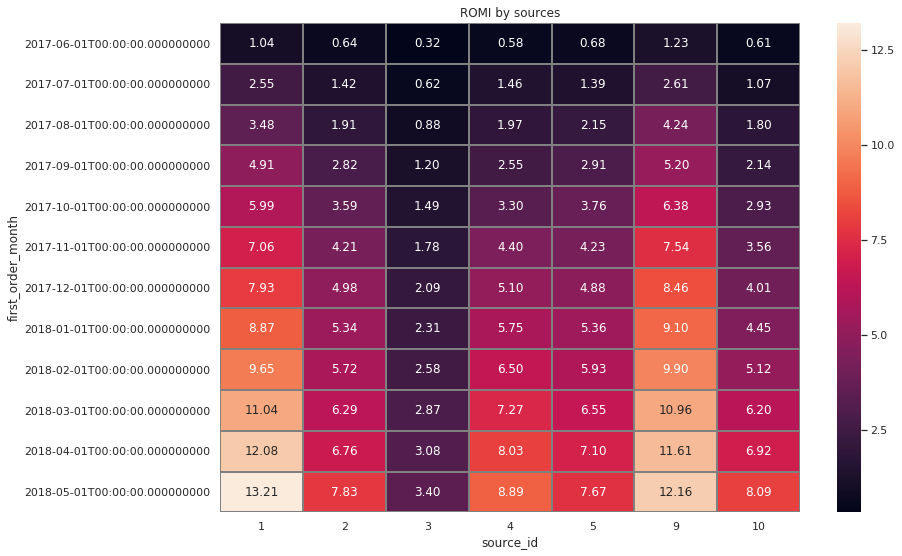

In [98]:
output_romi = report_by_source.pivot_table(
    index='first_order_month', columns = 'source_id', values='romi', aggfunc='mean'
)

output.cumsum().round(2) 

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI by sources')
sns.heatmap(output_romi.cumsum().round(2)  , annot=True, fmt='.2f', linewidths=1, linecolor='gray')

1 источник показывает лучшие результаты по окупаемости. 3 источник - неэффективнее остальных.

In [99]:
report_by_source

,first_order_month,first_source,order_month,n_buyers,revenue,month,source_id,costs,cac,gp,ltv,age,romi
0,2017-06-01,1,2017-06-01,203,1168.45,2017-06-01,1,1125.61,5.544877,1168.45,5.755911,0,1.038059
1,2017-06-01,1,2017-07-01,11,362.94,2017-07-01,1,1072.88,NaN,362.94,32.994545,1,NaN
2,2017-07-01,1,2017-07-01,211,1622.07,2017-07-01,1,1072.88,5.084739,1622.07,7.687536,0,1.511884
3,2017-06-01,1,2017-08-01,10,153.72,2017-08-01,1,951.81,NaN,153.72,15.372000,2,NaN
4,2017-07-01,1,2017-08-01,8,210.14,2017-08-01,1,951.81,NaN,210.14,26.267500,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2017-10-01,10,2018-04-01,1,3.67,2018-04-01,10,388.25,NaN,3.67,3.670000,6,NaN
509,2017-11-01,10,2018-04-01,1,1.47,2018-04-01,10,388.25,NaN,1.47,1.470000,5,NaN
510,2018-02-01,10,2018-04-01,3,15.89,2018-04-01,10,388.25,NaN,15.89,5.296667,2,NaN
511,2018-03-01,10,2018-04-01,4,11.79,2018-04-01,10,388.25,NaN,11.79,2.947500,1,NaN


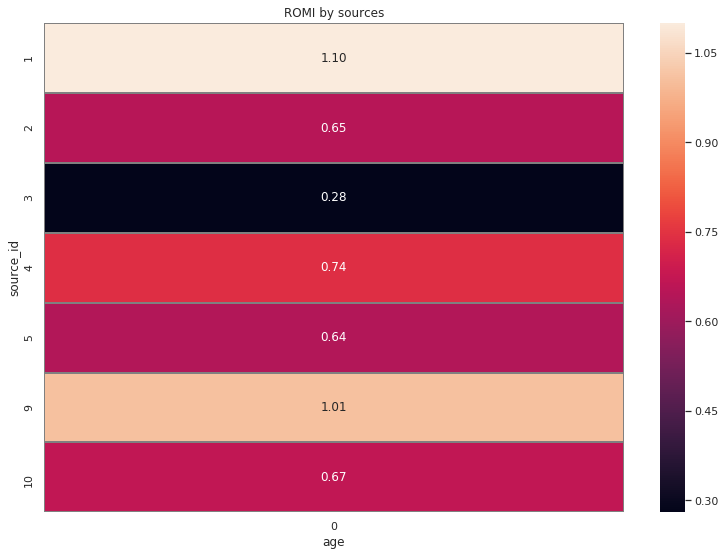

In [100]:
output_romi_by_sources = report_by_source.pivot_table(
    index='source_id', columns = 'age', values='romi', aggfunc='mean'
)

output_romi_by_sources.round(2) 

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI by sources')
sns.heatmap(output_romi_by_sources.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='gray')

Хорошие показатели окупаемости показывают 1 и 2 источники. Чего нельзя сказать о 3 источнике.

### Вывод

Были посчитаны различные маркетинговые метрики: <br>
- Всего потрачено на маркетинг 329131.62  
- Больше всего было потрачено на 3 source_id: 141321.63. При этом по количеству привлеченных клиентов он на втором месте. На первом - 4 source_id.
- САС в среднем составляет 9 у.е. 
- Больше всего потратили пользователи, пришедшие по 2 источнику. 
- В среднем все когорты окупаются на 8 месяц жизни. 

## Выводы и рекомендации

Сервисом пользуются редко: Retention  Rate в целом не превышает и 10%. При этом от когорты к когорте этот показатель продолжает снижаться. Это может свидетельствовать о переменах в работе сайте, которые не приходятся по душе пользователям. <br>
Покупка совершается как правило в течение 1 минуты. Средний чек - 6 у.е. <br>

Был проведен когортный анализ: особенно выделяется когорта сентября 2017 года: и по выручке, и по окупаемости, и по среднему чеку. При этом когорты 2018 года показывают наихудшие результаты - думаю, стоит учесть это при составлении плана рекламных кампаний - может быть, удачный опыт сентябрьской когорты подтолкнет на интересные идеи. <br>

Очень много тратится денег на 3 источник, при этом показатели привлечения посетителей у него сильно уступают остальным источникам. Думаю, может сместить фокус на другие источники - например, больше всего средств потратили люди, перешедшие по источнику 2, больше всего пользователей на сайт привлек 4 источник, а 1 источник окупался в первый же месяц. 